Demo Test Image: 


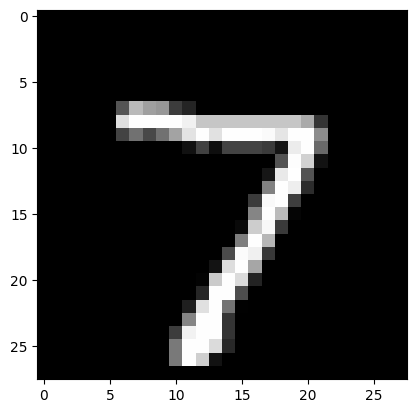

7


In [21]:
import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values to the range [-1, 1]
])
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=10, shuffle=True)

mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=10, shuffle=True)

print("Demo Test Image: ")
image,label=mnist_testset[0]
image=image.reshape(28,28)
plt.imshow(image, cmap='gray')
plt.show()
print(label)


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define a neural network model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.quant = torch.quantization.QuantStub()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dequant = torch.quantization.DeQuantStub()

    def forward(self, x): # uses relu activation function
        x = self.quant(x)
        x = torch.relu(self.fc1(x))
        x = torch.log_softmax(self.fc2(x), dim=1)
        x = self.dequant(x)
        return x

model = NeuralNetwork()
model.qconfig = torch.ao.quantization.default_qconfig
model.train()

model_quantized = torch.ao.quantization.prepare_qat(model,inplace=False)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

def train(train_loader, net, epochs=5, total_iterations_limit=None):
    cross_el = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    total_iterations = 0

    for epoch in range(epochs):
        model.train()

        loss_sum = 0
        num_iterations = 0

        for data in train_loader:
            num_iterations += 1
            total_iterations += 1
            x, y = data
            optimizer.zero_grad()
            output = net(x.view(-1, 784))
            loss = cross_el(output, y)
            loss_sum += loss.item()
            loss.backward()
            optimizer.step()

            if total_iterations_limit is not None and total_iterations >= total_iterations_limit:
                return
        
        print(f"Epoch {epoch+1}/{epochs}, Average Loss: {loss_sum / len(train_loader)}")

train(train_loader, model_quantized, epochs=5)

Epoch 1/5, Average Loss: 0.28092481360129506
Epoch 2/5, Average Loss: 0.14811403541449059
Epoch 3/5, Average Loss: 0.12233281199735939
Epoch 4/5, Average Loss: 0.1048716199971021
Epoch 5/5, Average Loss: 0.09405302003124863


In [4]:
model_quantized = torch.ao.quantization.convert(model_quantized)
model_quantized

NeuralNetwork(
  (quant): Quantize(scale=tensor([0.0157]), zero_point=tensor([64]), dtype=torch.quint8)
  (fc1): QuantizedLinear(in_features=784, out_features=512, scale=1.0101691484451294, zero_point=72, qscheme=torch.per_tensor_affine)
  (fc2): QuantizedLinear(in_features=512, out_features=10, scale=1.0301263332366943, zero_point=85, qscheme=torch.per_tensor_affine)
  (dequant): DeQuantize()
)

In [5]:
weights=[torch.int_repr(model_quantized.fc1.weight()).numpy(),torch.int_repr(model_quantized.fc2.weight()).numpy()]
biases=[model_quantized.fc1.bias().detach().numpy(),model_quantized.fc2.bias().detach().numpy()]
new_biases=[np.int8(biases[0]*100),np.int8(biases[1]*100)]

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def forward_pass(testset,weights,biases):
    true_labels = []
    predicted_labels = []
    for i in range(len(testset)):
        test_data,test_label=testset[i]
        img = test_data.view(1,-1)
        a=np.matmul(weights[0],img.T)+biases[0].reshape(-1,1)
        a=torch.relu(a)
        b=np.matmul(weights[1],a)+biases[1].reshape(-1,1) 
        y=torch.log_softmax(b,dim=0)
        y=torch.argmax(y).item()
        true_labels.append(test_label)
        predicted_labels.append(y)

    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)
    return true_labels,predicted_labels

true_labels,predicted_labels=forward_pass(mnist_testset,weights,new_biases)

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9691
Precision: 0.969131035670142
Recall: 0.9691021779311175


In [27]:
layer1=np.hstack((np.zeros((512,1)),weights[0],new_biases[0].reshape(-1,1)))
last_row=np.zeros((1,layer1.shape[1]))
last_row[:,-1]=1
layer1=np.vstack((layer1,last_row))
print(layer1.shape)
layer2=np.hstack((np.zeros((10,1)),weights[1],new_biases[1].reshape(-1,1)))
print(layer2.shape)
layer1 = list(map(int, layer1.reshape(-1)))
layer2 = list(map(int, layer2.reshape(-1)))

(513, 786)
(10, 514)


In [17]:
# convert to text and run run_fpga next
with open('layer1.txt', 'w') as file:
    for num in layer1:
        file.write("%d " % num)

with open('layer2.txt', 'w') as file:
    for num in layer2:
        file.write("%d " % num)

image,label=mnist_testset[0]
load_image = np.concatenate(([0], image.view(-1), [1])).astype(int)
load_image = list(map(int, load_image))
with open('image.txt', 'w') as file:
    for num in load_image:
        file.write("%d " % num)
print(label)